In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

def load_mnist_csv(filename):
    print(f"Loading {filename}...")
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File '{filename}' not found. Please ensure it is in the notebook folder.")
    
    df = pd.read_csv(filename, header=None)
    data = df.values
    
    # Check if first row is a header (strings), if so, remove it
    if isinstance(data[0,0], str):
        print(f"Header detected in {filename}, removing it...")
        data = data[1:].astype(float)
    else:
        data = data.astype(float)

    # Separate Label (Col 0) and Pixels (Cols 1-784)
    Y = data[:, 0]
    X = data[:, 1:]
    
    # Normalize to [0, 1]
    X = X / 255.0
    
    return X.astype(np.float32), Y.astype(int)


try:
    X_train, y_train = load_mnist_csv('mnist_train.csv')
    X_test, y_test   = load_mnist_csv('mnist_test.csv')
    
    print("Data loaded successfully!")
    print(f"Training Shape: {X_train.shape}")
    print(f"Testing Shape:  {X_test.shape}")
except Exception as e:
    print(f"CRITICAL ERROR: {e}")

Loading mnist_train.csv...


C:\Users\Rana\AppData\Local\Temp\ipykernel_6836\3093223765.py:17: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,2

Header detected in mnist_train.csv, removing it...
Loading mnist_test.csv...


C:\Users\Rana\AppData\Local\Temp\ipykernel_6836\3093223765.py:17: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,2

Header detected in mnist_test.csv, removing it...
Data loaded successfully!
Training Shape: (60000, 784)
Testing Shape:  (10000, 784)


In [2]:
#layer implementations
class Layer:
    def __init__(self, input_dim, output_dim,activation):
        # He Initialization
        scale = np.sqrt(2.0 / input_dim)
        self.weights = np.random.randn(input_dim, output_dim) * scale
        self.bias = np.zeros((1, output_dim))
        self.activation=activation
        #parameters for forward pass
        self.x = None
        self.z = None
        self.y = None
        #parameters for backward pass
        self.dW = None
        self.db = None
        

    def forward(self, x):
        self.x = x
        #z = Wx + b
        #y=activation(z)
        self.z=np.dot(x, self.weights) + self.bias
        if self.activation == 'relu':
            self.y = np.maximum(0, self.z)
        elif self.activation == 'sigmoid':
            self.y = 1 / (1 + np.exp(-self.z))
        elif self.activation == 'tanh':
            self.y = np.tanh(self.z)
        return self.y
        
        
    def backward(self, d_out):
        #dL/dZ=dL/dY*activation(z)
        if self.activation == 'relu':
            # Derivative is 1 if z > 0, else 0
            dz = d_out * (self.z > 0) 
            
        elif self.activation == 'sigmoid':
            # Derivative is a * (1 - a)
            dz = d_out * (self.y * (1 - self.y))
            
        elif self.activation == 'tanh':
            # Derivative is 1 - a^2
            dz = d_out * (1 - self.y**2)

        #dL/dW=dL/dY*dY/dW-->rate of change of loss wrt Y is X(y = Wx + b)
        #dL/dW=XT*dY/dW
        self.dW = np.dot(self.x.T, dz) # Use self.x (the input to this layer)
        # db = sum(dZ)
        self.db = np.sum(dz, axis=0, keepdims=True)
        # dX = dZ * W.T
        return np.dot(dz, self.weights.T) # this is the previous layer's d_out
    



In [3]:
class Autoencoder:
    def __init__(self,input_dim,bottleneck_dim):
        self.layers=[]

        #Encoder
        self.layers.append(Layer(input_dim, 256, 'relu'))     
        self.layers.append(Layer(256, 128, 'relu'))            
        self.layers.append(Layer(128, 64, 'relu'))             
        
        #Bottleneck
        self.layers.append(Layer(64, bottleneck_dim, 'relu')) 
        
        #Decoder
        self.layers.append(Layer(bottleneck_dim, 64, 'relu'))  
        self.layers.append(Layer(64, 128, 'relu'))             
        self.layers.append(Layer(128, 256, 'relu'))           
        self.layers.append(Layer(256, input_dim, 'sigmoid'))
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, loss_grad):
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)



In [4]:
#compute loss function and L2 regularization
def get_loss_and_L2Reg(Y,T):
    N = T.shape[0]
    # MSE Loss formula
    loss = np.mean((Y - T) ** 2)
    # Derivative of MSE: 2/N * (Prediction - Target)
    loss_grad = (2/N) * (Y - T)
    return loss, loss_grad

In [5]:
#Optimization
def optimization(model,lr,lambda_l2):
    #full equation:Wnew=Wold-lr*(dw+lambda*Wold)
    for layer in model.layers:
        #lambda*Woold
        weight_decay = lambda_l2 * layer.weights
        #lr*(dw+lambda*Wold)
        layer.weights -= lr * (layer.dW + weight_decay)
        #Wnew=Wold-lr*(dw+lambda*Wold)
        layer.bias-= lr * layer.db

In [6]:
#Get learning rate
def get_lr(initial_lr, epoch):
    # Decay the LR by 50% every 10 epochs
    drop_factor = 0.5
    epochs_drop = 10.0
    # Formula: lr * (0.5 ^ floor(epoch / 10))
    lr = initial_lr * math.pow(drop_factor, math.floor((1 + epoch) / epochs_drop))
    return lr

In [7]:
#Final training loop
def train(model, X_train, epochs, batch_size, initial_lr, lambda_l2):
    print(f"Starting training on {X_train.shape[0]} samples...")
    loss_history = []
    for epoch in range(epochs):
        # 1. Update Learning Rate
        current_lr = get_lr(initial_lr, epoch)
        
        # 2. Shuffle Data
        indices = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[indices]
        
        epoch_loss = 0
        num_batches = 0
        
        # 3. Mini-Batch Loop
        for i in range(0, X_train.shape[0], batch_size):
            # Get Batch
            x_batch = X_shuffled[i : i + batch_size]
            
            # A. Forward Pass
            # Autoencoder Input == Target
            y_pred = model.forward(x_batch)
            
            # B. Compute Loss
            loss, loss_grad = get_loss_and_L2Reg(y_pred, x_batch)
            epoch_loss += loss
            num_batches += 1
            
            # C. Backward Pass
            model.backward(loss_grad)
            
            # D. Optimization (Update Weights)
            optimization(model, current_lr, lambda_l2)
            
        # Print progress every epoch
        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | LR: {current_lr:.5f}")
    return loss_history

In [14]:
# Initialize and Train
model = Autoencoder(input_dim=784, bottleneck_dim=32)
loss_history = train(model, X_train, epochs=20, batch_size=64, initial_lr=0.01, lambda_l2=0.0)

Starting training on 60000 samples...
Epoch 1/20 | Loss: 0.0517 | LR: 0.01000
Epoch 2/20 | Loss: 0.0336 | LR: 0.01000
Epoch 3/20 | Loss: 0.0286 | LR: 0.01000
Epoch 4/20 | Loss: 0.0258 | LR: 0.01000
Epoch 5/20 | Loss: 0.0237 | LR: 0.01000
Epoch 6/20 | Loss: 0.0223 | LR: 0.01000
Epoch 7/20 | Loss: 0.0211 | LR: 0.01000
Epoch 8/20 | Loss: 0.0202 | LR: 0.01000
Epoch 9/20 | Loss: 0.0193 | LR: 0.01000
Epoch 10/20 | Loss: 0.0157 | LR: 0.00500
Epoch 11/20 | Loss: 0.0153 | LR: 0.00500
Epoch 12/20 | Loss: 0.0151 | LR: 0.00500
Epoch 13/20 | Loss: 0.0149 | LR: 0.00500
Epoch 14/20 | Loss: 0.0147 | LR: 0.00500
Epoch 15/20 | Loss: 0.0146 | LR: 0.00500
Epoch 16/20 | Loss: 0.0144 | LR: 0.00500
Epoch 17/20 | Loss: 0.0142 | LR: 0.00500
Epoch 18/20 | Loss: 0.0140 | LR: 0.00500
Epoch 19/20 | Loss: 0.0139 | LR: 0.00500
Epoch 20/20 | Loss: 0.0124 | LR: 0.00250


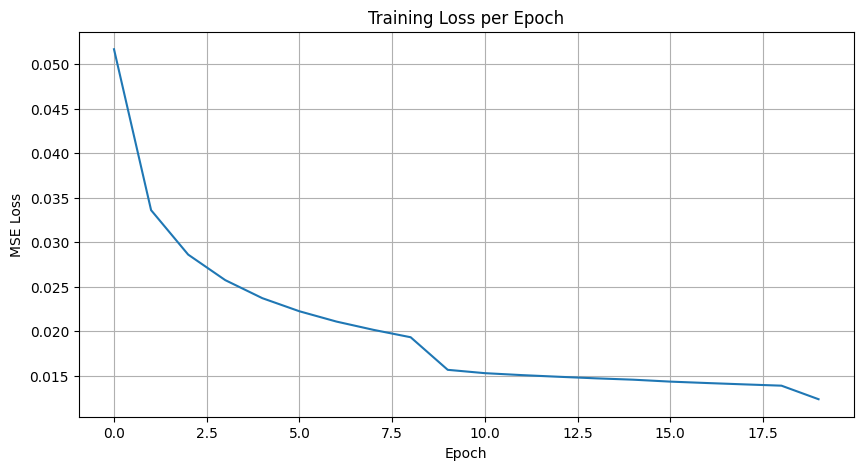

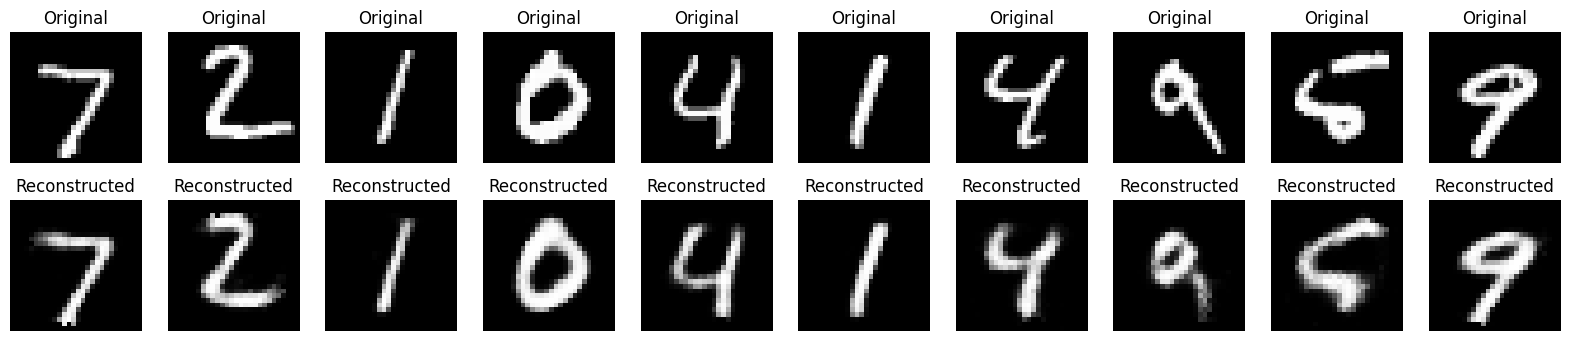

In [15]:
#Visualizations
# 2. Visualize Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# 3. Visualize Reconstructions
# Get reconstructions for the first 10 test images
num_images = 10
test_images = X_test[:num_images]
reconstructed = model.forward(test_images)

# Reshape back to 28x28 for display
test_images_reshaped = test_images.reshape(-1, 28, 28)
reconstructed_reshaped = reconstructed.reshape(-1, 28, 28)

plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Display Original
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(test_images_reshaped[i], cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Display Reconstructed
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_reshaped[i], cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()